##### Version (from Master_Thesis_MILP_v4.pdf) - this version implements random variation in demand (aggregator demand is subjected to stochastic behavior for the MC simulation)

In [1]:
from pyomo.environ import *
from scipy.stats import beta, weibull_min, multivariate_normal
from scipy.special import gamma
from random import choices
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

plt.style.use({'figure.facecolor':'white'})

In [2]:
def AGG_data_vis(model):
    for d_i in model.AGG:
        Pd = pd.DataFrame() # holds Pd, Pd_DR and Pd_IL kW
        cost = pd.DataFrame() # holds objective cost and savings $
        price = pd.DataFrame()  # dataframe holds price, DR_price $/kWh
        energy = pd.DataFrame()
        Pdmt = pd.DataFrame()
        Pdmt_max = pd.DataFrame()
        util = pd.DataFrame()
        blocks_m = ['d'+str(i+1) for i in range(model.NMd.value*34)]

        for t in model.TIME:
            price.loc[t, 'Price'] = model.ct[t].value/model.Sbase.value    # $/kWh
            price.loc[t, 'DR_price'] = model.c_DR[t].value/model.Sbase.value  # $/kWh
            for m in blocks_m:
                    for a,m_u,t_u in model.UTILS:
                        if a == d_i and t_u == t and m_u == m:
                            Pdmt.loc[t,m] = model.Pdmt[a,m,t].value*model.Sbase.value #kW
                            Pdmt_max.loc[t,m] = model.AGG_PblockMax[a,m,t].value*model.Sbase.value #kW
                            util.loc[t,m] = model.AGG_util[a,m,t].value/model.Sbase.value # $/kWh

            Pd.loc[t, 'Consumption'] = model.Pd[d_i,t].value*model.Sbase.value #kW
            Pd.loc[t, 'Demand Response'] = model.Pd_DR[d_i,t].value*model.Sbase.value #kW
            Pd.loc[t, 'Inflexible Load'] = model.AGG_LoadMin[d_i,t].value*model.Sbase.value #kW
            cost.loc[t, 'Objective'] = price.loc[t,'DR_price']*Pd.loc[t, 'Demand Response'] + \
                                       price.loc[t, 'Price']*Pd.loc[t, 'Inflexible Load'] - \
                                       sum(util.loc[t,m]*Pdmt.loc[t,m] for m in Pdmt.columns)
            cost.loc[t, 'Savings'] = (price.loc[t, 'Price']-price.loc[t, 'DR_price'])*Pd.loc[t, 'Demand Response']

        energy.loc[d_i, 'Energy'] = model.AGG_Einflex[d_i]*model.Sbase.value #kWh
        energy_tot = np.cumsum(Pd['Consumption'])   #kWh/day

        fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(14,8))
        ax[0,0].plot(Pd.index, energy_tot, linestyle='--', marker='o', alpha=0.6, label='$E_{cum}$')
        ax[0,0].fill_between(Pd.index, energy_tot, np.zeros(len(energy_tot)), alpha=0.5)
        ax[0,0].plot(Pd.index, Pd['Consumption'], marker='o', label='$P_{'+str(d_i)+',t}$');ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Active Power [kWh]');ax[0,0].set_title('Agg '+str(d_i)+' Consumption')
        ax[0,0].hlines(energy['Energy'], Pd.index[0], Pd.index[-1], colors='red', label='$E_{min}$')
        ax[0,0].legend(bbox_to_anchor=(0.1,0.7), loc='center', borderaxespad=0)
        ax[0,1].plot(price.index, price['Price'], marker='o', label='$c^R$', color='b')
        ax[0,1].plot(price.index, 0.9*price['Price'], marker='o', label='$c_{min}^t$', color='b')
        ax[0,1].fill_between(price.index, price['Price'], 0.9*price['Price'], alpha=0.5)
        ax[0,1].plot(price.index, price['DR_price'], marker='o', label='$c^{DR}$', color='orange');ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Price [$/kWh]');ax[0,1].set_title('Price')
        ax[0,1].legend(bbox_to_anchor=(0.1,0.7), loc='center', borderaxespad=0)
        util.plot(ax=ax[1,0], kind='bar', alpha=1, rot=0, edgecolor='white', linewidth=0.001);ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('Utility [$/kWh]');ax[1,0].set_title('Utility Blocks')
        Pdmt_max.plot(ax=ax[1,1], kind='bar', alpha=1, rot=0, edgecolor='white', linewidth=1, legend=None);ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('Active Power [kW]');ax[1,1].set_title('Consumption')
        Pdmt.plot(ax=ax[1,1], kind='bar', alpha=1, rot=0, edgecolor='black', linewidth=1, hatch='/')
        fig.tight_layout()
        plt.savefig('Visualization/aggregator_'+str(d_i)+'.png', bbox_inches='tight')
        plt.close()

        fig1, ax1 = plt.subplots(nrows=2, ncols=1, squeeze=False, figsize=(14,8))
        ax1[0,0].plot(cost.index, cost['Objective'], marker='o');ax1[0,0].set_xlabel('Time [h]');ax1[0,0].set_ylabel('Cost [$]');ax1[0,0].set_title('Agg '+str(d_i)+' Objective Cost')
        ax1[1,0].plot(cost.index, cost['Savings'], marker='o');ax1[1,0].set_xlabel('Time [h]');ax1[1,0].set_ylabel('Cost [$]');ax1[1,0].set_title('Agg '+str(d_i)+' Demand Response Savings')
        fig1.tight_layout()
        plt.savefig('Visualization/aggregator_'+str(d_i)+'_cost.png', bbox_inches='tight')
        plt.close()

def DSO_data_vis(model):
    lines = {(i,j) for i,j in model.LINES}
    voltage = pd.DataFrame()
    loading = pd.DataFrame(columns=lines, index=data['SystemDemand']['TIME'].values)
    active_d = pd.DataFrame()
    reactive_d = pd.DataFrame()
    active_s = pd.DataFrame()
    reactive_s = pd.DataFrame()
    active_pv = pd.DataFrame()
    active_wt = pd.DataFrame()
    reactive_wt = pd.DataFrame()
    SoC = pd.DataFrame()
    active_ch = pd.DataFrame()
    active_dis = pd.DataFrame()
    u_ess = pd.DataFrame()
    active_dg = pd.DataFrame()
    reactive_dg = pd.DataFrame()
    u_dg = pd.DataFrame()
    fuel_dg = pd.DataFrame()

    for t in model.TIME:
        for n in model.NODES:
            voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
            active_d.loc[t,n] = model.Pd[n,t].value*model.Sbase.value
            reactive_d.loc[t,n] = model.Qd[n,t].value*model.Sbase.value
            active_s.loc[t,n] = model.Ps[n,t].value*model.Sbase.value
            reactive_s.loc[t,n] = model.Qs[n,t].value*model.Sbase.value
        for p in model.PV:
            active_pv.loc[t,p] = model.Ppv[p,t].value*model.Sbase.value
        for w in model.WT:
            active_wt.loc[t,w] = model.Pwt[w,t].value*model.Sbase.value
            reactive_wt.loc[t,w] = model.Qwt[w,t].value*model.Sbase.value
        for s in model.EES:
            SoC.loc[t,s] = model.SOC[s,t].value
            active_ch.loc[t,s] = model.Pch[s,t].value*model.Sbase.value
            active_dis.loc[t,s] = model.Pdis[s,t].value*model.Sbase.value
            u_ess.loc[t,s] = model.u_ess[s,t].value
        for g in model.DG:
            active_dg.loc[t,g] = model.Pdg[g,t].value*model.Sbase.value
            reactive_dg.loc[t,g] = model.Qdg[g,t].value*model.Sbase.value
            u_dg.loc[t,g] = model.u_dg[g,t].value
            fuel_dg.loc[t,g] = model.Fdg[g,t].value

    for i,j in lines:
        for t in model.TIME:
            loading.loc[t, pd.IndexSlice[i, j]] = np.sqrt(model.I[i,j,t].value)*model.Sbase.value

    loading = loading.sort_index(axis=1)

    # Active and reactive power demand and supply (supply only from from slack bus)
    fig_pow, ax_pow = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
    ax_pow[0,0].plot(active_d.index, active_d, marker='o');ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Active Power Demand')
    ax_pow[0,1].plot(reactive_d.index, reactive_d, marker='o');ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Reactive Power Demand')
    ax_pow[1,0].plot(active_s.index, active_s, marker='o');ax_pow[1,0].set_xlabel('Time [h]');ax_pow[1,0].set_ylabel('Active Power [kW]');ax_pow[1,0].set_title('Active Power Supply')
    ax_pow[1,1].plot(reactive_s.index, reactive_s, marker='o');ax_pow[1,1].set_xlabel('Time [h]');ax_pow[1,1].set_ylabel('Reactive Power [kVar]');ax_pow[1,1].set_title('Reactive Power Supply')
    fig_pow.legend(['Bus'+str(i) for i in active_d.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pow.tight_layout()
    plt.savefig('Visualization/power.png', bbox_inches='tight')
    plt.close()

    # PV active power generation
    fig_pv, ax_pv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    ax_pv[0,0].plot(active_pv.index, active_pv, marker='o');ax_pv[0,0].set_xlabel('Time [h]');ax_pv[0,0].set_ylabel('Active Power [kW]');ax_pv[0,0].set_title('PV Active Power Supply')
    fig_pv.legend(['Bus'+str(i) for i in active_pv.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pv.tight_layout()
    plt.savefig('Visualization/pv.png', bbox_inches='tight')
    plt.close()

    # Wind active and reactive power supply
    fig_wt, ax_wt = plt.subplots(nrows=2, ncols=1, squeeze=False, figsize=(12,8))
    ax_wt[0,0].plot(active_wt.index, active_wt, marker='o');ax_wt[0,0].set_xlabel('Time [h]');ax_wt[0,0].set_ylabel('Active Power [kW]');ax_wt[0,0].set_title('Wind Active Power Supply')
    ax_wt[1,0].plot(reactive_wt.index, reactive_wt, marker='o');ax_wt[1,0].set_xlabel('Time [h]');ax_wt[1,0].set_ylabel('Active Power [kW]');ax_wt[1,0].set_title('Wind Reactive Power Supply')
    fig_wt.legend(['Bus'+str(i) for i in active_wt.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_wt.tight_layout()
    plt.savefig('Visualization/wt.png', bbox_inches='tight')
    plt.close()

    # Distributed generation supply
    fig_dg, ax_dg = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
    ax_dg[0,0].plot(active_dg.index, active_dg, marker='o');ax_dg[0,0].set_xlabel('Time [h]');ax_dg[0,0].set_ylabel('Active Power [kW]');ax_dg[0,0].set_title('DG Active Power Supply')
    ax_dg[0,1].plot(active_dg.index, reactive_dg, marker='o');ax_dg[0,1].set_xlabel('Time [h]');ax_dg[0,1].set_ylabel('Reactive Power [kVar]');ax_dg[0,1].set_title('DG Reactive Power Supply')
    ax_dg[1,0].plot(active_dg.index, u_dg, marker='o');ax_dg[1,0].set_xlabel('Time [h]');ax_dg[1,0].set_ylabel('State');ax_dg[1,0].set_title('DG working state')
    ax_dg[1,1].plot(active_dg.index, fuel_dg, marker='o');ax_dg[1,1].set_xlabel('Time [h]');ax_dg[1,1].set_ylabel('Fuel [m$^3$]');ax_dg[1,1].set_title('DG fuel')
    fig_dg.legend(['Bus'+str(i) for i in active_dg.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_dg.tight_layout()
    plt.savefig('Visualization/dg.png', bbox_inches='tight')
    plt.close()

    # Voltage profile
    b=['Bus'+str(i) for i in active_d.columns]
    b.extend({'$V_{min}$','$V_{max}$'})
    fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    ax_v[0,0].plot(voltage.index, voltage, marker='o');ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage')
    ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--')
    ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--')
    ax_v[0,0].legend(b, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    fig_v.tight_layout()
    plt.savefig('Visualization/voltage.png', bbox_inches='tight')
    plt.close()

    # Current profile
    fig_i, ax_i = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    ax_i[0,0].plot(loading.index, loading, marker='o');ax_i[0,0].set_xlabel('Time [h]');ax_i[0,0].set_ylabel('Current [kA]');ax_i[0,0].set_title('Current')
    fig_i.legend(['Line '+str(i)+'-'+str(j) for i,j in loading.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_i.tight_layout()
    plt.savefig('Visualization/current.png', bbox_inches='tight')
    plt.close()

    # SOC and charging state of storage systems
    fig_ees, ax_ees = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
    ax_ees[0,0].plot(SoC.index, SoC, marker='o');ax_ees[0,0].set_xlabel('Time [h]');ax_ees[0,0].set_ylabel('SoC [%]');ax_ees[0,0].set_title('State of Charge')
    ax_ees[0,1].plot(active_ch.index, active_ch, marker='o');ax_ees[0,1].set_xlabel('Time [h]');ax_ees[0,1].set_ylabel('Active Power [kW]');ax_ees[0,1].set_title('Charging Active Power')
    ax_ees[1,0].plot(u_ess.index, u_ess, marker='o');ax_ees[1,0].set_xlabel('Time [h]');ax_ees[1,0].set_ylabel('State');ax_ees[1,0].set_title('Charging State')
    ax_ees[1,1].plot(active_dis.index, active_dis, marker='o');ax_ees[1,1].set_xlabel('Time [h]');ax_ees[1,1].set_ylabel('Active Power [kW]');ax_ees[1,1].set_title('Discharging Active Power')
    fig_ees.legend(['Bus' + str(s) for s in SoC.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_ees.tight_layout()
    plt.savefig('Visualization/ees.png', bbox_inches='tight')
    plt.close()

In [3]:
def read_input(filename):
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    SystemDemand = pd.read_excel(filename, sheet_name='SystemDemand')
    PVData = pd.read_excel(filename, sheet_name='PVData')
    PVGeneration = pd.read_excel(filename, sheet_name='PVGeneration')
    WindData = pd.read_excel(filename, sheet_name='WindData')
    WindGeneration = pd.read_excel(filename, sheet_name='WindGeneration')
    Storage = pd.read_excel(filename, sheet_name='Storages')
    LineData = pd.read_excel(filename, sheet_name='LineData')
    CableTypes = pd.read_excel(filename, sheet_name='CableTypes')
    DGs = pd.read_excel(filename, sheet_name='DGs')
    AggData = pd.read_excel(filename, sheet_name='AggData')
    DemandBlocks = pd.read_excel(filename, sheet_name='DemandBlocks')
    UtilTimeMul = pd.read_excel(filename, sheet_name='UtilTimeMul')

    return {'SystemDemand':SystemDemand, 'NodeData':NodeData, 'PVData':PVData, 'PVGeneration':PVGeneration,
            'WindData':WindData, 'WindGeneration':WindGeneration, 'Storage':Storage,  'LineData':LineData,
            'CableTypes':CableTypes, 'DGs':DGs, 'AggData':AggData, 'DemandBlocks':DemandBlocks,
            'UtilTimeMul':UtilTimeMul}

def optimization_model(inputData, Vmax, Vmin, Vnom, Sbase, Zbase, case, eta_conf, base_model):
    #---------------------------------------------------------------------------------------------------------
    #Inputs
    #---------------------------------------------------------------------------------------------------------
    # Upper Level
    NodeData = inputData['NodeData']
    LineData = inputData['LineData']
    CableTypes = inputData['CableTypes']
    SystemDemand = inputData['SystemDemand']
    PVData = inputData['PVData']
    PVGeneration = inputData['PVGeneration']
    WindData = inputData['WindData']
    WindGeneration = inputData['WindGeneration']
    StorageData = inputData['Storage']
    DGData = inputData['DGs']
    AggData = inputData['AggData']
    UtilTimeMul = inputData['UtilTimeMul']

    if case == 'BC':
        NMd = 4     # number of demand blocks of DR aggregator
        DemandBlocks = inputData['DemandBlocks']

    # LEADER
    time = [SystemDemand.loc[i, 'TIME'] for i in SystemDemand.index]
    lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
    buses = [NodeData.loc[i, 'NODES'] for i in NodeData.index]
    pvs = [PVData.loc[i,'NODES'] for i in PVData.index]
    wts = [WindData.loc[i,'NODES'] for i in WindData.index]
    storages = [StorageData.loc[i,'NODES'] for i in StorageData.index]
    DGs = [DGData.loc[i,'NODES'] for i in DGData.index]
    aggs = [AggData.loc[i, 'AGG'] for i in AggData.index]

    if case == 'BC':
        dblocks = [DemandBlocks.loc[i, 'DB'] for i in DemandBlocks.index]
        utils = {(aggs[a], dblocks[d + NMd*a], time[t]) for a in AggData.index for d in range(NMd) for t in UtilTimeMul.index}

    # LEADER
    R = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'R'].iloc[0] for i in LineData.index}    #km*ohm/km
    X = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'X'].iloc[0] for i in LineData.index}    #km*ohm/km
    B = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'B'].iloc[0] for i in LineData.index}    #km*pu/km
    Tb = {buses[i]:NodeData.loc[i, 'Tb'] for i in NodeData.index}   #slack bus flag
    Ss_max = {buses[i]: NodeData.loc[i, 'Smax']/Sbase for i in NodeData.index}  # kVA -> pu

    # random variables for renewables
    mu_st = {(pvs[i], time[t]):PVGeneration.loc[t, 'mean'] for t in PVGeneration.index for i in PVData.index}
    var_st = {(pvs[i], time[t]):PVGeneration.loc[t, 'variance'] for t in PVGeneration.index for i in PVData.index}
    mu_wt = {(wts[i], time[t]):WindGeneration.loc[t, 'mean'] for t in WindGeneration.index for i in WindData.index}
    var_wt = {(wts[i], time[t]):WindGeneration.loc[t, 'variance'] for t in WindGeneration.index for i in WindData.index}

    Ppvpp = {pvs[i]:PVData.loc[i, 'PPV']/Sbase for i in PVData.index}
    Qpv = {(pvs[i], time[k]):PVData.loc[i, 'QPV']*PVGeneration.loc[k, 'QPV']/Sbase for k in PVGeneration.index for i in PVData.index}   #kW -> p.u.

    Pwpp = {wts[i]:WindData.loc[i, 'PWT']/Sbase for i in WindData.index}
    Qwt = {(wts[i], time[k]):WindData.loc[i, 'QWT']*WindGeneration.loc[k, 'QWT']/Sbase for k in WindGeneration.index for i in WindData.index}   #kW -> p.u.
    wsin = 3                #Cut-in wind speed in (m/s)
    wsr = 12                #Rated wind speed in (m/s)
    wsout = 20              #Cut-off wind speed in (m/s)

    if case == 'BC':
        ESS_Pmax = {storages[i]:StorageData.loc[i, 'Power']/Sbase for i in StorageData.index}   #kW -> p.u.
        ESS_SOCmax = {storages[i]:StorageData.loc[i, 'Energy']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
        ESS_SOCmin = {storages[i]:0 for i in StorageData.index} #%
        ESS_SOCini = {storages[i]:StorageData.loc[i, 'SOEini']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
        ESS_Eff = {storages[i]:StorageData.loc[i, 'Eff'] for i in StorageData.index}    #unitless
        ESS_SOEmax = {storages[i]:StorageData.loc[i, 'Energy'] for i in StorageData.index} #kWh

        DG_FC = {DGs[i]:DGData.loc[i, 'FC'] for i in DGData.index}             #m^3
        DG_H = {DGs[i]:DGData.loc[i, 'H']/Sbase for i in DGData.index}         #kWh/m^3 -> pu
        DG_Eff = {DGs[i]:DGData.loc[i, 'eff'] for i in DGData.index}           #%
        DG_pf = {DGs[i]:DGData.loc[i, 'pf'] for i in DGData.index}
        DG_Rup = {DGs[i]:DGData.loc[i, 'Rup']/Sbase for i in DGData.index}     #kW/h -> pu
        DG_Rdw = {DGs[i]:DGData.loc[i, 'Rdw']/Sbase for i in DGData.index}     #kW/h -> pu
        DG_Smax = {DGs[i]:DGData.loc[i, 'Smax']/Sbase for i in DGData.index}   #kW -> pu

        # FOLLOWER
        RU = {aggs[i]:AggData.loc[i, 'RU']/Sbase for i in AggData.index}  # ramp up rate kW/h -> pu
        RD = {aggs[i]:AggData.loc[i, 'RD']/Sbase for i in AggData.index}  # ramp down rate kW/h -> pu
        MargUtil = {(aggs[a], dblocks[d + NMd*a], time[t]):UtilTimeMul.loc[t,'UtilMultiplier']*DemandBlocks.loc[DemandBlocks['AGG'] == \
                    AggData.loc[a, 'AGG']]['MargUtil'].iloc[d]/1000*Sbase for a in AggData.index for d in range(NMd) for t in UtilTimeMul.index}  # $/MWh -> $/kWh -> $/pu
        # max block size is set to 1/4 of maximum load (utility divided into 4 equal blocks with different height) for full time frame (user should always be able to consume that)
        Load = {(aggs[a], dblocks[d + NMd*a], time[t]):AggData.loc[a, 'PD']/NMd/Sbase for a in AggData.index for d in range(NMd) for t in UtilTimeMul.index}  # kW -> pu
        # inflexible load is 20% of nominal consumption
        LoadMin = {(aggs[a], time[t]):0.2*AggData.loc[a, 'PD']/Sbase for a in AggData.index  for t in UtilTimeMul.index}  # kW -> pu
        Energy = {aggs[a]:sum(AggData.loc[a, 'PD']*SystemDemand.loc[t, 'PD']/Sbase for t in UtilTimeMul.index) for a in AggData.index}  # kWh -> pu
        AGG_pf = {aggs[i]:AggData.loc[i, 'pf'] for i in AggData.index}  #unitless
        Pdini = {aggs[i]:AggData.loc[i, 'PDini']/Sbase for i in AggData.index}  # kW -> pu
    Price = {time[t]:UtilTimeMul.loc[t, 'Price']/1000*Sbase for t in UtilTimeMul.index}  # $/MWh -> $/kWh -> $/pu

    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    model = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    # LEADER
    model.LINES = Set(initialize=lines, ordered=False)
    model.NODES = Set(initialize=buses)
    model.TIME = Set(ordered=True, initialize=time)
    model.PV = Set(initialize=pvs)
    model.WT = Set(initialize=wts)
    model.EES = Set(initialize=storages)
    model.DG = Set(initialize=DGs)
    # FOLLOWER
    model.AGG = Set(initialize=aggs)

    if case == 'BC':
        model.UTILS = Set(initialize=utils, ordered=False)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    # LEADER

    #Network
    model.R = Param(model.LINES, initialize=R, mutable=True, within=NonNegativeReals)   #ohm
    model.X = Param(model.LINES, initialize=X, mutable=True, within=NonNegativeReals)   #ohm
    model.B = Param(model.LINES, initialize=B, mutable=True, within=NonNegativeReals)   #pu
    model.Vmax = Param(initialize=Vmax, mutable=True) # p.u.
    model.Vmin = Param(initialize=Vmin, mutable=True) # p.u.
    model.Vnom = Param(initialize=1.0, mutable=True)  # p.u.
    model.Ss_max = Param(model.NODES, initialize=Ss_max, mutable=True, within=NonNegativeReals)      #pu
    model.Sbase = Param(initialize=Sbase)
    model.ct = Param(model.TIME, initialize=Price, mutable=True, within=NonNegativeReals)

    #Load
    model.Tb = Param(model.NODES, initialize=Tb, mutable=True, within=Any)

    #PV generation
    model.Ppvpp = Param(model.PV, initialize=Ppvpp)
    model.Qpv = Param(model.PV, model.TIME, initialize=Qpv, mutable=True, within=Any)       #pu
    model.mu_st = Param(model.PV, model.TIME, initialize=mu_st, mutable=True, within=Any)
    model.var_st = Param(model.PV, model.TIME, initialize=var_st, mutable=True, within=Any)

    #Wind generation
    model.Pwpp = Param(model.WT, initialize=Pwpp)
    model.Qwt = Param(model.WT, model.TIME, initialize=Qwt, mutable=True, within=Any)       #pu
    model.mu_wt = Param(model.WT, model.TIME, initialize=mu_wt, mutable=True, within=Any)
    model.var_wt = Param(model.WT, model.TIME, initialize=var_wt, mutable=True, within=Any)
    model.wsin = Param(initialize=wsin)                 #Cut-in wind speed in (m/s)
    model.wsr = Param(initialize=wsr)                   #Rated wind speed in (m/s)
    model.wsout = Param(initialize=wsout)               #Cut-off wind speed in (m/s)

    #Random variable confidence
    model.eta_conf = Param(initialize=eta_conf)

    if case == 'BC':
        #Energy storage system
        model.ESS_Pmax = Param(model.EES, initialize=ESS_Pmax, within=NonNegativeReals, mutable=True)       #pu
        model.ESS_SOCmax = Param(model.EES, initialize=ESS_SOCmax, within=NonNegativeReals, mutable=True)   #%
        model.ESS_SOCmin = Param(model.EES, initialize=ESS_SOCmin, within=NonNegativeReals, mutable=True)   #%
        model.ESS_SOCini = Param(model.EES, initialize=ESS_SOCini, within=NonNegativeReals, mutable=True)   #%
        model.ESS_Eff = Param(model.EES, initialize=ESS_Eff, within=NonNegativeReals, mutable=True)
        model.ESS_SOEmax = Param(model.EES, initialize=ESS_SOEmax, within=NonNegativeReals, mutable=True)   #kWh

        #Distributed Generation
        model.DG_FC = Param(model.DG, initialize=DG_FC, within=NonNegativeReals, mutable=True)
        model.DG_H = Param(model.DG, initialize=DG_H, within=NonNegativeReals, mutable=True)
        model.DG_Eff = Param(model.DG, initialize=DG_Eff, within=NonNegativeReals, mutable=True)
        model.DG_pf = Param(model.DG, initialize=DG_pf, within=NonNegativeReals, mutable=True)
        model.DG_Rup = Param(model.DG, initialize=DG_Rup, within=NonNegativeReals, mutable=True)
        model.DG_Rdw = Param(model.DG, initialize=DG_Rdw, within=NonPositiveReals, mutable=True)
        model.DG_Smax = Param(model.DG, initialize=DG_Smax, within=NonNegativeReals, mutable=True)

        # FOLLOWER

        model.NMd = Param(initialize=NMd)
        model.AGG_Pdini = Param(model.AGG, initialize=Pdini, mutable=True, within=Any)
        model.AGG_RD = Param(model.AGG, initialize=RD, mutable=True, within=NonPositiveReals)
        model.AGG_RU = Param(model.AGG, initialize=RU, mutable=True, within=NonNegativeReals)
        model.AGG_util = Param(model.UTILS, mutable=True, initialize=MargUtil, within=NonNegativeReals)
        model.AGG_PblockMax = Param(model.UTILS, mutable=True, initialize=Load, within=NonNegativeReals)
        model.AGG_LoadMin = Param(model.AGG, model.TIME, mutable=True, initialize=LoadMin, within=NonNegativeReals)
        model.AGG_Etot = Param(model.AGG, initialize=Energy, mutable=True, within=NonNegativeReals)
        model.AGG_pf = Param(model.AGG, initialize=AGG_pf, mutable=True, within=Any)
        #Big M values from Fortuny-Amat transformation
        k = 100
        k = Sbase/Vnom  # A
        model.M1 = Param(initialize=k*Sbase/Sbase, mutable=True, within=NonNegativeReals)
        model.M2 = Param(initialize=k*Sbase/Sbase, mutable=True, within=NonNegativeReals)
        model.M3 = Param(initialize=k*Sbase/Sbase, mutable=True, within=NonNegativeReals)
        model.M4 = Param(initialize=k*Sbase/Sbase, mutable=True, within=NonNegativeReals)
        model.M5 = Param(initialize=k*Sbase/Sbase, mutable=True, within=NonNegativeReals)
        model.M6 = Param(initialize=k*Sbase/Sbase, mutable=True, within=NonNegativeReals)

    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    # LEADER

    def ini_resistance(model, i,j):
        return model.R[i,j]/Zbase
    model.RM = Param(model.LINES, rule=ini_resistance)  # p.u.
    def ini_reactance(model, i,j):
        return model.X[i,j]/Zbase
    model.XM = Param(model.LINES, rule=ini_reactance)   # p.u.
    def ini_susceptance(model, i,j):
        return model.B[i,j]
    model.BM = Param(model.LINES, rule=ini_susceptance) # p.u.

    # FOLLOWER
    if case == 'BC':
        def inflexible_energy(model, a):
            return model.AGG_Etot[a]*0.6
        model.AGG_Einflex = Param(model.AGG, rule=inflexible_energy)

    # RANDOM VARIABLES

    def pv_active_power(model, pv, t):
        if model.mu_st[pv,t] == 0:
            return 0
        else:
            b = (1 - mu_st[pv,t])*(mu_st[pv,t]*(1 + mu_st[pv,t])/var_st[pv,t] - 1)
            a = mu_st[pv,t]*b/(1 - mu_st[pv,t])
            if case == 'MC':
                irrad_spectrum = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
                irrad = choices(irrad_spectrum, beta.pdf(irrad_spectrum, a, b))[0]
                return model.Ppvpp[pv]*irrad
            elif case == 'BC':
                irrad = beta.ppf(1 - eta_conf, a, b)
                return model.Ppvpp[pv]*irrad
    model.Ppv = Param(model.PV, model.TIME, rule=pv_active_power)

    def wt_active_power(model, wt, t):
        kappa = (np.sqrt(var_wt[wt,t])/mu_wt[wt,t])**(-1.086)
        lambd = mu_wt[wt,t]/gamma(1 + 1/kappa)

        if case == 'MC':
            wind_spectrum = np.linspace(weibull_min.ppf(0.01, kappa, scale=lambd), weibull_min.ppf(0.99, kappa, scale=lambd), 100)
            wind = choices(wind_spectrum, weibull_min.pdf(wind_spectrum, kappa, scale=lambd))[0]
        elif case == 'BC':
            wind = weibull_min.ppf(1 - eta_conf, kappa, scale=lambd)

        if wind < wsin:
            return 0
        elif wsin < wind < wsr:
            return model.Pwpp[wt]*(wind**3 - model.wsin**3)/(model.wsr**3 - model.wsin**3)
        elif model.wsr < wind < model.wsout:
            return model.Pwpp[wt]
        elif wind[t] > wsout:
            return 0
    model.Pwt = Param(model.WT, model.TIME, rule=wt_active_power)

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    # LEADER

    #Network
    model.I = Var(model.LINES, model.TIME, initialize=0)
    model.P = Var(model.LINES, model.TIME, initialize=0)
    model.Q = Var(model.LINES, model.TIME, initialize=0)

    def ini_voltage(model, n, t):
        if model.Tb[n] == 0:
            temp = model.Vnom
            model.V[n,t].fixed = False
        else:
            temp = model.Vnom
            model.V[n,t].fixed = True
        return temp
    model.V = Var(model.NODES, model.TIME, initialize=ini_voltage)

    #Energy storage system
    def ini_Pch(model, s, t):
        if case == 'MC':
            temp = base_model.Pch[s,t].value
            model.Pch[s,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Pch[s,t].fixed = False
        return temp
    model.Pch = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=ini_Pch)

    def ini_Pdis(model, s, t):
        if case == 'MC':
            temp = base_model.Pdis[s,t].value
            model.Pdis[s,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Pdis[s,t].fixed = False
        return temp
    model.Pdis = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=ini_Pdis)

    def ini_u_ees(model, s, t):
        if case == 'MC':
            temp = base_model.u_ess[s,t].value
            model.u_ess[s,t].fixed = True
            if abs(temp - 1) < 10E-5:
                temp = 1
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.u_ess[s,t].fixed = False
        return temp
    model.u_ess = Var(model.EES, model.TIME, within=Binary, initialize=ini_u_ees)

    if case == 'BC':
        def initial_SOC_rule(model, s, t):
            return model.ESS_SOCini[s].value
        model.SOC = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=initial_SOC_rule)

    #Supply (slack bus, else 0)
    def active_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Ps[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Ps = Var(model.NODES, model.TIME, initialize=active_supply_rule, within=Reals)

    def reactive_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Qs[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Qs = Var(model.NODES, model.TIME, initialize=reactive_supply_rule, within=Reals)

    #Distributed generation
    def ini_Pdg(model, d, t):
        if case == 'MC':
            temp = base_model.Pdg[d,t].value
            model.Pdg[d,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Pdg[d,t].fixed = False
        return temp
    model.Pdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=ini_Pdg)

    def ini_Qdg(model, d, t):
        if case == 'MC':
            temp = base_model.Qdg[d,t].value
            model.Qdg[d,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Qdg[d,t].fixed = False
        return temp
    model.Qdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=ini_Qdg)

    if case == 'BC':
        model.Fdg = Var(model.DG, model.TIME, within=NonNegativeReals)
        model.u_dg = Var(model.DG, model.TIME, within=Binary)

        #Price for demand response
        model.c_DR = Var(model.TIME, within=NonNegativeReals)

    # FOLLOWER

    # Aggregator

    if case == 'MC':
        Ptemp = {(aggs[i], time[t]):0 for i in AggData.index for t in SystemDemand.index}
        Qtemp =  copy.deepcopy(Ptemp)
        for t in base_model.TIME:
            for a in base_model.AGG:
                #if load is < 6.75kW ignore stochastic behavior due to numerical instability (negative eigen values)
                #multivariate_normal requires positive semi-definite matrix - for 0.6 correlation
                if base_model.Pd[a,t].value > 10E-5:
                    PQcorr = 0.8
                    mean = [base_model.Pd[a,t].value*base_model.Sbase.value, base_model.Qd[a,t].value*base_model.Sbase.value]
                    variance = [mean[0]*0.1, mean[1]*0.1]
                    Ptemp[a,t] = np.random.normal(mean[0], np.sqrt(variance[0]))
                    A = mean[1] + np.sqrt(variance[1])/np.sqrt(variance[0])*PQcorr*(Ptemp[a,t] - mean[0])
                    D = (1 - PQcorr**2)*variance[1]
                    Qtemp[a,t] = np.random.normal(A, np.sqrt(D))/base_model.Sbase.value
                    Ptemp[a,t] = Ptemp[a,t]/base_model.Sbase.value
                else:
                    Ptemp[a,t], Qtemp[a,t] = 0,0
                if Qtemp[a,t] < 0:
                    Qtemp[a,t] = 0
                if Ptemp[a,t] < 0:
                    Ptemp[a,t] = 0

    def ini_Pd(model, a, t):
        if case == 'MC':
            temp = Ptemp[a,t]
            model.Pd[a,t].fixed = True
        elif case == 'BC':
            temp = 0
            model.Pd[a,t].fixed = False
        return temp
    model.Pd = Var(model.AGG, model.TIME, within=NonNegativeReals, initialize=ini_Pd)

    def ini_Qd(model, a, t):
        if case == 'MC':
            temp = Qtemp[a,t]
            model.Qd[a,t].fixed = True
        elif case == 'BC':
            temp = 0
            model.Qd[a,t].fixed = False
        return temp
    model.Qd = Var(model.AGG, model.TIME, within=NonNegativeReals, initialize=ini_Qd)

    if case == 'BC':
        model.Pd_DR = Var(model.AGG, model.TIME, within=NonNegativeReals)
        model.Pdmt = Var(model.UTILS, within=NonNegativeReals, initialize=0)

        #Lagrange multipliers and Fortuny-Amat binary variables
        model.mu1 = Var(model.UTILS, within=NonNegativeReals)
        model.mu2 = Var(model.UTILS, within=NonNegativeReals)
        model.mu3 = Var(model.AGG, within=NonNegativeReals)
        model.mu4 = Var(model.AGG, model.TIME, within=NonNegativeReals)
        model.mu5 = Var(model.AGG, model.TIME, within=NonNegativeReals)
        model.mu6 = Var(model.AGG, model.TIME, within=NonNegativeReals)
        model.lamb1 = Var(model.AGG, model.TIME, within=Reals)
        model.lamb2 = Var(model.AGG, model.TIME, within=Reals)
        model.lamb3 = Var(model.AGG, model.TIME, within=Reals)
        model.z1 = Var(model.UTILS, within=Binary)
        model.z2 = Var(model.UTILS, within=Binary)
        model.z3 = Var(model.AGG, within=Binary)
        model.z4 = Var(model.AGG, model.TIME, within=Binary)
        model.z5 = Var(model.AGG, model.TIME, within=Binary)
        model.z6 = Var(model.AGG, model.TIME, within=Binary)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------
    # Objective function - equation (1)
    def act_loss(model):
        return sum(model.ct[t]*model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES for t in model.TIME)
    model.obj = Objective(rule=act_loss)

    #---------------------------------------------------------------------------------------------------------
    #Define LEADER Constraints
    #---------------------------------------------------------------------------------------------------------

    #Nodal Power balance - equation (2) and (3)
    def active_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind + Power_discharged = Power_out + Power_out_lost + Power_consumed + Power_charged
        return sum(model.P[i,j,t] for i,j in model.LINES if j == k) + model.Ps[k,t] + sum(model.Ppv[p,t] for p in model.PV if p==k) + \
               sum(model.Pwt[w,t] for w in model.WT if w==k) + sum(model.Pdis[s,t] for s in model.EES if s == k) + sum(model.Pdg[g,t] for g in model.DG if g == k) == \
               sum(model.P[i,j,t] + model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES if i == k) + model.Pd[k,t] + sum(model.Pch[s,t] for s in model.EES if s == k)
    model.active_power_flow = Constraint(model.NODES, model.TIME, rule=active_power_flow_rule)

    def reactive_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind = Power_out + Power_out_lost + Power_consumed
        return sum(model.Q[i,j,t] + (model.V[j,t])*model.BM[i,j]/2 for i,j in model.LINES if j == k) + model.Qs[k,t] + sum(model.Qpv[p,t] for p in model.PV if p == k) + \
               sum(model.Qwt[w,t] for w in model.WT if w == k) + sum(model.Qdg[g,t] for g in model.DG if g == k) == \
               sum(model.Q[i,j,t] + model.XM[i,j]*(model.I[i,j,t]) - (model.V[i,t])*model.BM[i,j]/2 for i,j in model.LINES if i == k) + model.Qd[k,t]
    model.reactive_power_flow = Constraint(model.NODES, model.TIME, rule=reactive_power_flow_rule)

    # Network constraints - equation (4), (5), (6) and (7)
    def voltage_drop_rule(model, i, j, t):
        return (model.V[i,t]) - (model.V[j,t]) - 2*(model.RM[i,j]*model.P[i,j,t] + model.XM[i,j]*model.Q[i,j,t]) - (model.RM[i,j]**2 + model.XM[i,j]**2)*model.I[i,j,t] == 0
    model.voltage_drop = Constraint(model.LINES, model.TIME, rule=voltage_drop_rule)

    if case == 'MC':
        def define_current_rule(model, i, j, t):
            return (model.V[j,t])*(model.I[i,j,t]) == (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
        model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

        def voltage_limit_rule(model, n, t):
            return inequality(model.Vmin**2/2, model.V[n,t], 2*model.Vmax**2)
        model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

    elif case == 'BC':
        def define_current_rule(model, i, j, t):
            return (model.V[j,t])*(model.I[i,j,t]) >= (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
        model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

        def voltage_limit_rule(model, n, t):
            return inequality(model.Vmin**2, model.V[n,t], model.Vmax**2)
        model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

        def current_limit_rule(model, i, j, t):
            return 0 <= model.I[i,j,t]
        model.current_limit = Constraint(model.LINES, model.TIME, rule=current_limit_rule)

        def slack_bus_trafo_limit_rule(model, n, t):
            if model.Tb[n] == 1:
                return model.Ps[n,t]**2 + model.Qs[n,t]**2 <= Ss_max[n]**2
            else:
                return (model.Ps[n,t] - model.Pd[n,t] + sum(model.Ppv[p,t] for p in model.PV if p==n) + sum(model.Pwt[w,t] for w in model.WT if w==n) - \
                        sum(model.Pdis[s,t] - model.Pch[s,t] for s in model.EES if s == n) + sum(model.Pdg[g,t] for g in model.DG if g == n))**2 + \
                        (model.Qs[n,t] - model.Qd[n,t] + sum(model.Qpv[p,t] for p in model.PV if p==n) + sum(model.Qwt[w,t] for w in model.WT if w==n))**2 <= \
                        model.Ss_max[n]**2
        model.slack_bus_trafo_limit = Constraint(model.NODES, model.TIME, rule=slack_bus_trafo_limit_rule)

        # Storage constraints - equation (8), (9), (10) and (11) (equation 12 incorporated in Define Variables)
        def ESS_SOCupdate_rule(model, s, t):
            if model.TIME.ord(t) == 1:
                return model.SOC[s,t] == model.ESS_SOCini[s] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
            if model.TIME.ord(t) > 1:
                return model.SOC[s,t] == model.SOC[s,model.TIME.prev(t)] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
        model.EES_SOCupdate = Constraint(model.EES, model.TIME, rule=ESS_SOCupdate_rule)

        def ESS_SOClimit_rule(model, s, t):
            return inequality(model.ESS_SOCmin[s], model.SOC[s,t], model.ESS_SOCmax[s])
        model.ESS_SOClimit = Constraint(model.EES, model.TIME, rule=ESS_SOClimit_rule)

        def ESS_Charging_rule(model, s, t):
            return model.Pch[s,t] <= model.ESS_Pmax[s]*model.u_ess[s,t]
        model.ESS_Charging = Constraint(model.EES, model.TIME, rule=ESS_Charging_rule)

        def ESS_Discharging_rule(model, s, t):
            return model.Pdis[s,t] <= model.ESS_Pmax[s]*(1-model.u_ess[s,t])
        model.ESS_Discharging = Constraint(model.EES, model.TIME, rule=ESS_Discharging_rule)

        def DSO_price_rule(model, t):
            return inequality(0.83*model.ct[t], model.c_DR[t], model.ct[t])
        model.DSO_price = Constraint(model.TIME, rule=DSO_price_rule)

        #Distributed generation constraints - equation (13a), (13b), (14), (15), (16) and (17) (equation 18 incorporated in Define Variables)

        def dg_powerfactor_cap_rule(model, g, t):
            return model.Pdg[g,t]*tan(acos(model.DG_pf[g])) >= model.Qdg[g,t]
        model.dg_powerfactor_cap = Constraint(model.DG, model.TIME, rule=dg_powerfactor_cap_rule)

        def dg_powerfactor_ind_rule(model, g, t):
            return -model.Pdg[g,t]*tan(acos(model.DG_pf[g])) <= model.Qdg[g,t]
        model.dg_powerfactor_ind = Constraint(model.DG, model.TIME, rule=dg_powerfactor_ind_rule)

        def dg_capacity_limit_rule(model, g, t):
            return (model.Pdg[g,t])**2 + (model.Qdg[g,t])**2 <= model.u_dg[g,t]*(model.DG_Smax[g])**2
        model.dg_capacity_limit = Constraint(model.DG, model.TIME, rule=dg_capacity_limit_rule)

        def dg_ramp_up_down_rule(model, g, t):
            if model.TIME.ord(t) == 1:
                # the DG is initially off
                return inequality(model.DG_Rdw[g], model.Pdg[g,t] - 0, model.DG_Rup[g])
            if model.TIME.ord(t) > 1:
                return inequality(model.DG_Rdw[g], model.Pdg[g,t] - model.Pdg[g,model.TIME.prev(t)], model.DG_Rup[g])
        model.dg_ramp_up_down = Constraint(model.DG, model.TIME, rule=dg_ramp_up_down_rule)

        def dg_fuel_rule(model, g, t):
            if model.TIME.ord(t) == 1:
                # set arbitrary initial amount of fuel (800 cubic meters)
                return model.Fdg[g,t] == 300 - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
            if model.TIME.ord(t) > 1:
                return model.Fdg[g,t] == model.Fdg[g,model.TIME.prev(t)] - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
        model.dg_fuel = Constraint(model.DG, model.TIME, rule=dg_fuel_rule)

        def dg_min_fuel_rule(model, g, t):
            return model.Fdg[g,t] >= 0
        model.dg_min_fuel = Constraint(model.DG, model.TIME, rule=dg_min_fuel_rule)

        #---------------------------------------------------------------------------------------------------------
        #Define FOLLOWER Constraints
        #---------------------------------------------------------------------------------------------------------

        #Stationarity conditions - equation (30), (29) and (32)
        def agg_Pit_stationarity_rule(model, a, t):
            if model.TIME.ord(t) == model.TIME.last():
                return model.lamb1[a,t] + model.lamb3[a,t] - model.mu3[a] - model.mu4[a,t] + model.mu5[a,t] - model.mu6[a,t] \
                       - model.lamb2[a,t]*np.tan(np.arccos(model.AGG_pf[a].value)) == 0
            else:
                return model.lamb1[a,t] + model.lamb3[a,t] - model.mu3[a] - model.mu4[a,t] + model.mu5[a,t] - model.mu6[a,t] \
                       - model.mu5[a,model.TIME.next(t)] + model.mu6[a,model.TIME.next(t)] \
                       - model.lamb2[a,t]*np.tan(np.arccos(model.AGG_pf[a].value)) == 0
        model.agg_Pit_stationarity = Constraint(model.AGG, model.TIME, rule=agg_Pit_stationarity_rule)

        def agg_Pimt_stationarity_rule(model, a_i, a, m, t):
            if a_i == a:
                return -model.AGG_util[a,m,t] - model.lamb1[a,t] + model.mu1[a,m,t] - model.mu2[a,m,t] == 0
            else:
                return Constraint.Skip
        model.agg_Pimt_stationarity = Constraint(model.AGG, model.UTILS, rule=agg_Pimt_stationarity_rule)

        def agg_Qit_stationarity_rule(model, a, t):
            return model.lamb2[a,t] == 0
        model.agg_Qit_stationarity = Constraint(model.AGG, model.TIME, rule=agg_Qit_stationarity_rule)

        def agg_PDR_stationarity_rule(model, a, t):
            return model.c_DR[t] - model.lamb3[a,t] == 0
        model.agg_PDR_stationarity = Constraint(model.AGG, model.TIME, rule=agg_PDR_stationarity_rule)

        #Primal feasibility - equation (33), (34), (35), (36), (37), (38), (39) and (40)

        def aggregated_load_rule(model, a_i, t_i):
            return model.Pd[a_i,t_i] - sum(model.Pdmt[a,m,t] for a,m,t in model.UTILS if a == a_i and t == t_i) == 0
        model.aggregated_load = Constraint(model.AGG, model.TIME, rule=aggregated_load_rule)

        def max_block_size_rule(model, a_i, a, m, t):
            if a_i == a:
                return  model.Pdmt[a,m,t] - model.AGG_PblockMax[a,m,t] <= 0
            else:
                return Constraint.Skip
        model.max_block_size = Constraint(model.AGG, model.UTILS, rule=max_block_size_rule)

        def min_block_size_rule(model, a_i, a, m, t):
            if a_i == a:
                return -model.Pdmt[a,m,t] <= 0
            else:
                return Constraint.Skip
        model.min_block_size = Constraint(model.AGG, model.UTILS, rule=min_block_size_rule)

        def total_energy_rule(model, a):
            return model.AGG_Einflex[a] - sum(model.Pd[a,t] for t in model.TIME) <= 0
        model.total_energy = Constraint(model.AGG, rule=total_energy_rule)

        # now min power consumption at time t is set to 0 (can be set to amount of inflexible load)
        def agg_min_consumption_rule(model, a, t):
            return model.AGG_LoadMin[a,t] - model.Pd[a,t] <= 0
        model.agg_min_consumption = Constraint(model.AGG, model.TIME, rule=agg_min_consumption_rule)

        def agg_ramp_up_rule(model, a, t):
            if model.TIME.ord(t) == 1:
                return model.Pd[a,t] - model.AGG_Pdini[a] - model.AGG_RU[a] <= 0
            elif model.TIME.ord(t) > 1:
                return model.Pd[a,t] - model.Pd[a,model.TIME.prev(t)] - model.AGG_RU[a] <= 0
        model.agg_ramp_up = Constraint(model.AGG, model.TIME, rule=agg_ramp_up_rule)

        def agg_ramp_down_rule(model, a, t):
            if model.TIME.ord(t) == 1:
                # for testing purposes initialize initial consumption to 1 MW
                return model.AGG_RD[a] - model.Pd[a,t] + model.AGG_Pdini[a] <= 0
            elif model.TIME.ord(t) > 1:
                return model.AGG_RD[a] - model.Pd[a,t] + model.Pd[a,model.TIME.prev(t)] <= 0
        model.agg_ramp_down = Constraint(model.AGG, model.TIME, rule=agg_ramp_down_rule)

        def agg_pf_rule(model, a, t):
            return model.Qd[a,t] - model.Pd[a,t]*np.tan(np.arccos(model.AGG_pf[a].value)) == 0
        model.agg_pf = Constraint(model.AGG, model.TIME, rule=agg_pf_rule)

        def agg_demand_response_rule(model, a, t):
            return model.Pd[a,t] - model.Pd_DR[a,t] - model.AGG_LoadMin[a,t] == 0
        model.agg_demand_response = Constraint(model.AGG, model.TIME, rule=agg_demand_response_rule)

        #Dual feasibility - equation (41), (42), (43) and (44) (all equations incorporated in Define Variables)

        #Complementary slackness - equation (51) - (59) (equations 57-59 incorporated in Define Variables)

        def max_block_size_csA_rule(model, a_i, a, m, t):
            if a_i == a:
                return  model.Pdmt[a,m,t] - model.AGG_PblockMax[a,m,t] >= -model.M1*model.z1[a,m,t]
            else:
                return Constraint.Skip
        model.max_block_size_csA = Constraint(model.AGG, model.UTILS, rule=max_block_size_csA_rule)

        def min_block_size_csA_rule(model, a_i, a, m, t):
            if a_i == a:
                return -model.Pdmt[a,m,t] >= -model.M2*model.z2[a,m,t]
            else:
                return Constraint.Skip
        model.min_block_size_csA = Constraint(model.AGG, model.UTILS, rule=min_block_size_csA_rule)

        def total_energy_csA_rule(model, a):
            return model.AGG_Einflex[a] - sum(model.Pd[a,t] for t in model.TIME) >= -model.M3*model.z3[a]
        model.total_energy_csA = Constraint(model.AGG, rule=total_energy_csA_rule)

        # now min power consumption at time t is set to 0 (can be set to amount of inflexible load)
        def agg_min_consumption_csA_rule(model, a, t):
            return model.AGG_LoadMin[a,t] - model.Pd[a,t] >= -model.M4*model.z4[a,t]
        model.agg_min_consumption_csA = Constraint(model.AGG, model.TIME, rule=agg_min_consumption_csA_rule)

        def agg_ramp_up_csA_rule(model, a, t):
            if model.TIME.ord(t) == 1:
                return model.Pd[a,t] - model.AGG_Pdini[a] - model.AGG_RU[a] >= -model.M5*model.z5[a,t]
            elif model.TIME.ord(t) > 1:
                return model.Pd[a,t] - model.Pd[a,model.TIME.prev(t)] - model.AGG_RU[a] >= -model.M5*model.z5[a,t]
        model.agg_ramp_up_csA = Constraint(model.AGG, model.TIME, rule=agg_ramp_up_csA_rule)

        def agg_ramp_down_csA_rule(model, a, t):
            if model.TIME.ord(t) == 1:
                # for testing purposes initialize initial consumption to 1 MW
                return model.AGG_RD[a] - model.Pd[a,t] + model.AGG_Pdini[a] >= -model.M6*model.z6[a,t]
            elif model.TIME.ord(t) > 1:
                return model.AGG_RD[a] - model.Pd[a,t] + model.Pd[a,model.TIME.prev(t)] >= -model.M6*model.z6[a,t]
        model.agg_ramp_down_csA = Constraint(model.AGG, model.TIME, rule=agg_ramp_down_csA_rule)

        def max_block_size_csB_rule(model, a_i, a, m, t):
            if a_i == a:
                return model.mu1[a,m,t] <= model.M1*(1-model.z1[a,m,t])
            else:
                return Constraint.Skip
        model.max_block_size_csB = Constraint(model.AGG, model.UTILS, rule=max_block_size_csB_rule)

        def min_block_size_csB_rule(model, a_i, a, m, t):
            if a_i == a:
                return model.mu2[a,m,t] <= model.M2*(1-model.z2[a,m,t])
            else:
                return Constraint.Skip
        model.min_block_size_csB = Constraint(model.AGG, model.UTILS, rule=min_block_size_csB_rule)

        def total_energy_csB_rule(model, a):
            return model.mu3[a] <= model.M3*(1-model.z3[a])
        model.total_energy_csB = Constraint(model.AGG, rule=total_energy_csB_rule)

        # now min power consumption at time t is set to 0 (can be set to amount of inflexible load)
        def agg_min_consumption_csB_rule(model, a, t):
            return model.mu4[a,t] <= model.M4*(1-model.z4[a,t])
        model.agg_min_consumption_csB = Constraint(model.AGG, model.TIME, rule=agg_min_consumption_csB_rule)

        def agg_ramp_up_csB_rule(model, a, t):
            return model.mu5[a,t] <= model.M5*(1-model.z5[a,t])
        model.agg_ramp_up_csB = Constraint(model.AGG, model.TIME, rule=agg_ramp_up_csB_rule)

        def agg_ramp_down_csB_rule(model, a, t):
            return model.mu6[a,t] <= model.M6*(1-model.z6[a,t])
        model.agg_ramp_down_csB = Constraint(model.AGG, model.TIME, rule=agg_ramp_down_csB_rule)

    return model

In [4]:
%%time
data = read_input(r'Input_Files\InputData34_v4congested.xlsx')
Sbase = 1000 # kVA
Vnom = 11/np.sqrt(3)    # kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Vmax = 1.05  # pu
Vmin = 0.95  # pu
case = 'BC'
eta_conf = 50/100   # %/%
base_model = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, case, eta_conf, 0)
#model.pprint()
#model.display()

Wall time: 6.13 s


In [5]:
%%time
solver = SolverFactory('cplex')
solver.solve(base_model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\FILIPF~1\AppData\Local\Temp\tmp2tleua7t.cplex.log' open.
CPLEX> Problem 'C:\Users\FILIPF~1\AppData\Local\Temp\tmpxv1f7skc.pyomo.lp' read.
Read time = 0.08 sec. (4.50 ticks)
CPLEX> Problem name         : C:\Users\FILIPF~1\AppData\Local\Temp\tmpxv1f7skc.pyomo.lp
Objective sense      : Minimize
Variables            :   29709  [Nneg: 15035,  Free: 5664,  Binary: 9010]
Objective nonzeros   :     792
Linear constraints   :   40615  [Less: 28158,  Greater: 1776,  Equal: 10681]
  Nonzeros           :   91091
  RHS nonzeros       :   25360
Quadratic constraints:    1656  [Less: 1656]
  Linear 

{'Problem': [{'Name': 'tmpxv1f7skc', 'Lower bound': 115.57902035, 'Upper bound': 115.59007795872614, 'Number of objectives': 1, 'Number of constraints': 40615, 'Number of variables': 29709, 'Number of nonzeros': 91091, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': 13.19, 'Termination condition': 'optimal', 'Termination message': 'MIP - Integer optimal, tolerance (0.0001/1e-06)\\x3a Objective = 1.1559007796e+02', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 13.588886260986328}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [6]:
# CHECK LOSSES+DEMAND=SUPPLY
cost = value(base_model.obj)
losses = sum(value(base_model.RM[i,j])*value(base_model.I[i,j,t]) for i,j in base_model.LINES for t in base_model.TIME)
supply = sum(sum(value(base_model.Pdg[g,t]) for g in base_model.DG if g) + sum(value(base_model.Ps[n, t]) for n in base_model.NODES) + sum(value(base_model.Ppv[p, t]) for p in base_model.PV) + sum(value(base_model.Pwt[w,t]) for w in base_model.WT) + sum(value(base_model.Pdis[s, t]) for s in base_model.EES) for t in base_model.TIME)
demand = sum(sum(value(base_model.Pd[n, t]) for n in base_model.NODES) + sum(value(base_model.Pch[s, t]) for s in base_model.EES) for t in base_model.TIME)

print('Supply: {s:.3f} [kWh/day] \nDemand: {d:.3f} [kWh/day] \nLosses: {l:.3f} [kWh/day]'.format(s=supply*Sbase, d=demand*Sbase, l=losses*Sbase))
print('Supply = Demand + Losses: {:.3f} [kWh/day]'.format(demand*Sbase + losses*Sbase))

Supply: 47723.876 [kWh/day] 
Demand: 45447.413 [kWh/day] 
Losses: 2276.421 [kWh/day]
Supply = Demand + Losses: 47723.834 [kWh/day]


In [7]:
# %%time
# AGG_data_vis(base_model)
# DSO_data_vis(base_model)

In [8]:
def MonteCarlo_vis(model, l, a, mrk):
    voltage = pd.DataFrame()
    active_pv = pd.DataFrame()
    active_wt = pd.DataFrame()
    active_s = pd.DataFrame()
    reactive_s = pd.DataFrame()
    apparent_s = pd.DataFrame()
    active_d = pd.DataFrame()
    reactive_d = pd.DataFrame()

    for t in model.TIME:
        for n in model.NODES:
            if n == 27:
                voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
            if n == 1:
                active_s.loc[t,n] = model.Ps[n,t].value*model.Sbase.value
                reactive_s.loc[t,n] = model.Qs[n,t].value*model.Sbase.value
                apparent_s.loc[t,n] = np.sqrt(active_s.loc[t,n]**2 + reactive_s.loc[t,n]**2)
            if n == 15:
                active_d.loc[t,n] = model.Pd[n,t].value*model.Sbase.value
                reactive_d.loc[t,n] = model.Qd[n,t].value*model.Sbase.value
        for p in model.PV:
            active_pv.loc[t,p] = model.Ppv[p,t]*model.Sbase.value
        for w in model.WT:
            active_wt.loc[t,w] = model.Pwt[w,t]*model.Sbase.value
    Ss_max = model.Ss_max[1].value*model.Sbase.value

    # PV active power generation
    ax_pv[0,0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.9, 5)])
    ax_pv[0,0].plot(active_pv.index, active_pv, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5, label=[['Bus'+str(i) for i in active_pv.columns]]);ax_pv[0,0].set_xlabel('Time [h]');ax_pv[0,0].set_ylabel('Active Power [kW]');ax_pv[0,0].set_title('PV Active Power Supply')
    fig_pv.legend(['Bus'+str(i) for i in active_pv.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pv.tight_layout();
    if l == 2:
        fig_pv.savefig('PV.png', bbox_inches='tight')

    # Wind active power generation
    ax_wt[0,0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.9, 4)])
    ax_wt[0,0].plot(active_wt.index, active_wt, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_wt[0,0].set_xlabel('Time [h]');ax_wt[0,0].set_ylabel('Active Power [kW]');ax_wt[0,0].set_title('Wind Active Power Supply')
    fig_wt.legend(['Bus'+str(i) for i in active_wt.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_wt.tight_layout();
    if l == 2:
        fig_wt.savefig('WT.png', bbox_inches='tight')

    # Voltage
    ax_v[0,0].plot(voltage.index, voltage, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage')
    if l == 2:
        ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--', label='$V_{min}$')
        ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--', label='$V_{max}$')
    #ax_v[0,0].legend(bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_v.tight_layout();
    if l == 2:
        fig_v.savefig('V.png', bbox_inches='tight')

    # Active and reactive power demand and supply (supply only from slack bus)
    ax_pow[0,0].plot(active_s.index, active_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Active Power Supply')
    ax_pow[0,1].plot(reactive_s.index, reactive_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Reactive Power Supply')
    fig_pow.legend(['Slack Bus'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pow.tight_layout();
    if l == 2:
        fig_pow.savefig('PQ.png', bbox_inches='tight')

    # Apparent power
    ax_apow[0,0].plot(reactive_s.index, apparent_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_apow[0,0].set_xlabel('Time [h]');ax_apow[0,0].set_ylabel('Apparent Power [kVA]');ax_apow[0,0].set_title('Slack Bus Power Supply');
    if l == 2:
        ax_apow[0,0].axhline(Ss_max, color='r', linestyle='--', label='$S_{max}$')
    #fig_apow.legend(bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
    fig_apow.tight_layout();
    if l == 2:
        fig_apow.savefig('S.png', bbox_inches='tight')

    # Active and reactive power demand from bus 15
    ax_dem[0,0].plot(active_d.index, active_d, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_dem[0,0].set_xlabel('Time [h]');ax_dem[0,0].set_ylabel('Active demand [kW]');ax_dem[0,0].set_title('Active Power Demand')
    ax_dem[0,1].plot(reactive_d.index, reactive_d, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_dem[0,1].set_xlabel('Time [h]');ax_dem[0,1].set_ylabel('Reactive demand [kVar]');ax_dem[0,1].set_title('Reactive Power Demand')
    fig_dem.legend(['Bus 15'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_dem.tight_layout();
    if l == 2:
        fig_dem.savefig('PQdem.png', bbox_inches='tight')

Wall time: 3.03 s


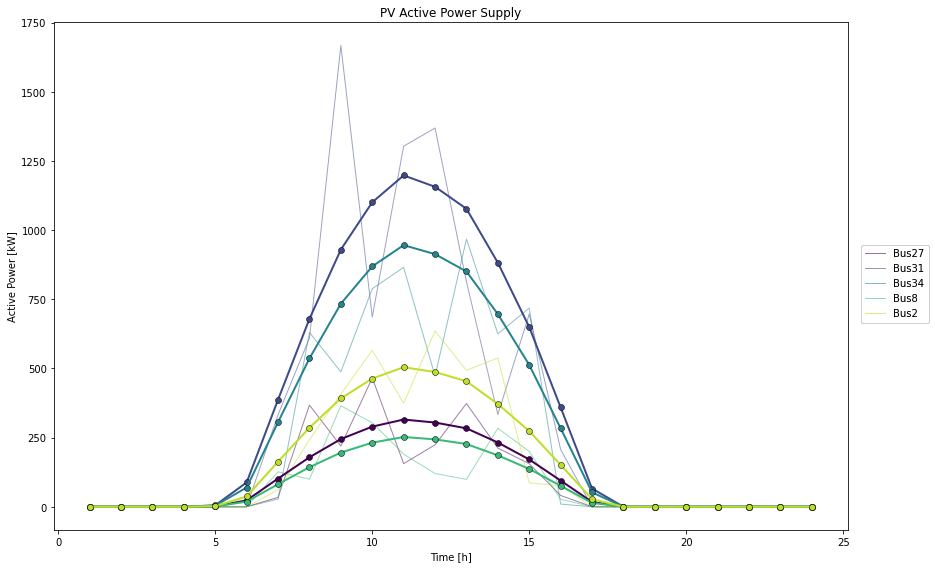

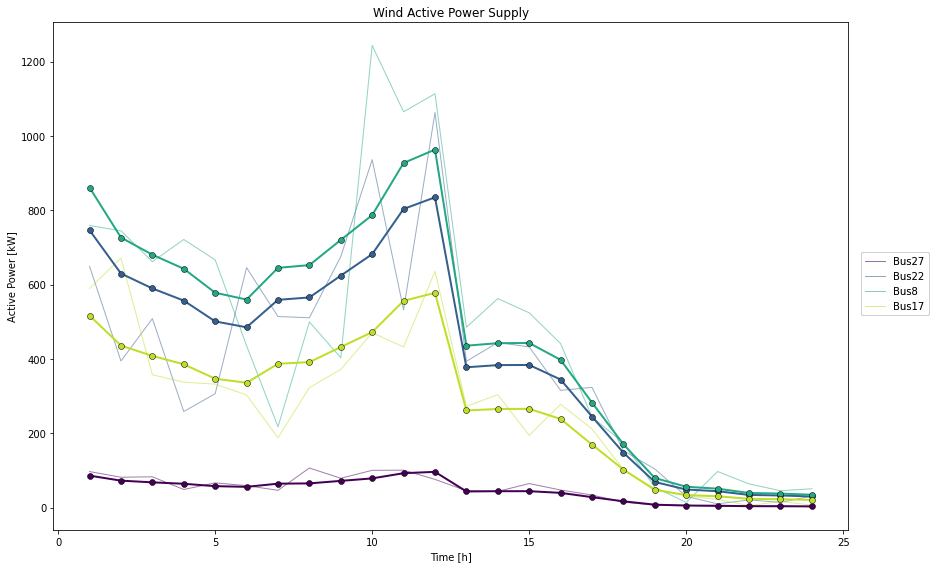

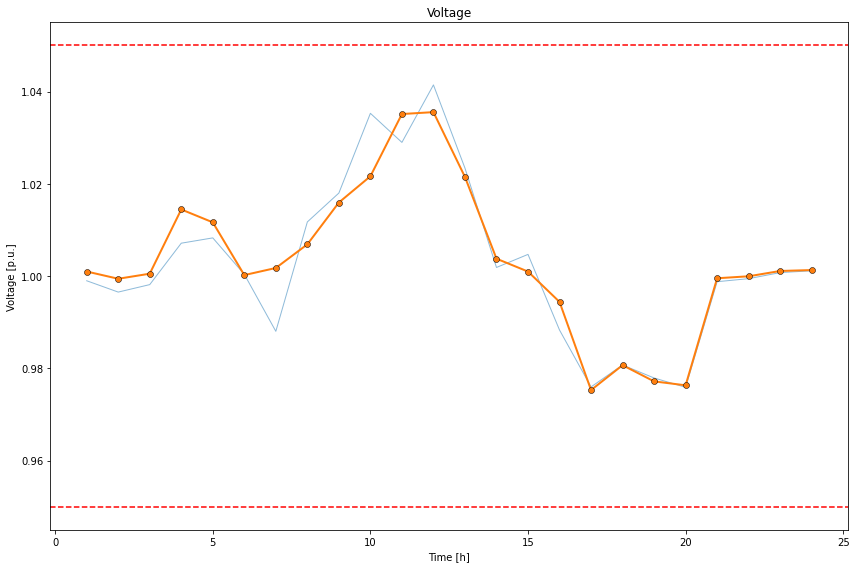

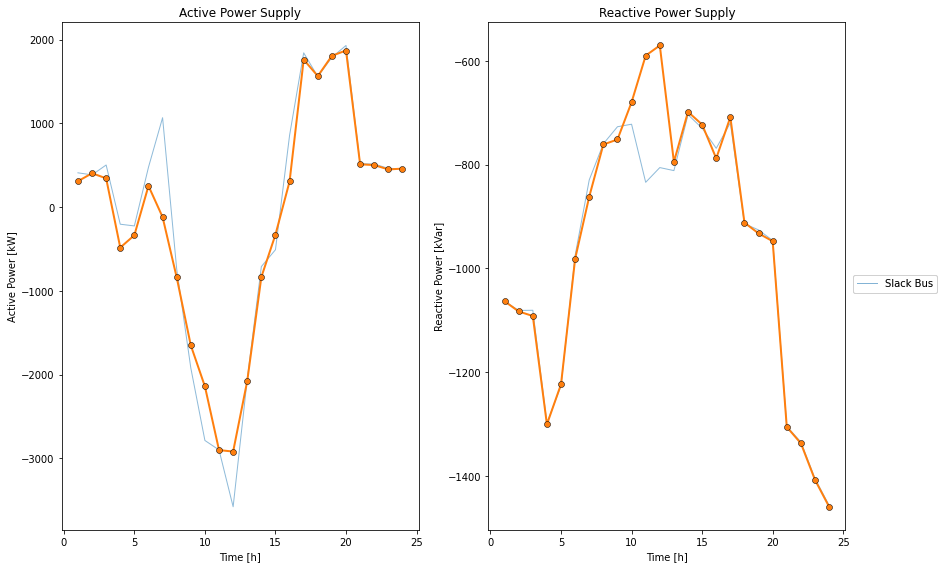

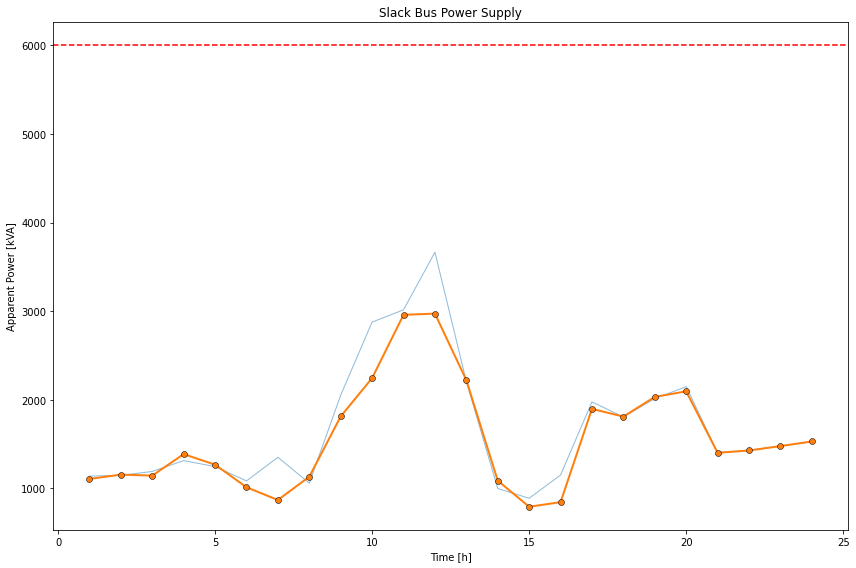

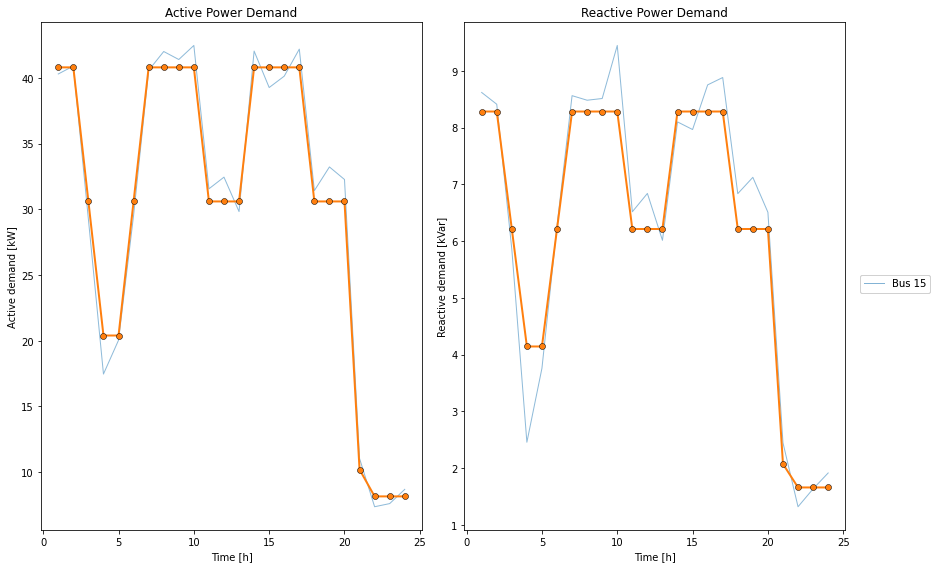

In [9]:
%%time
#initialize Monte Carlo model with fixed control variables and relaxed network constraints

case = 'MC'
fig_pv, ax_pv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_wt, ax_wt = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_pow, ax_pow = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12,8))
fig_apow, ax_apow = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_dem, ax_dem = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12,8))
solver = SolverFactory('ipopt')

for i in range(1):
    MonteCarlo_model = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, case, eta_conf, base_model)
    # solve Monte Carlo model with fixed control variables
    solver.solve(MonteCarlo_model)  #, tee=True)
    MonteCarlo_vis(MonteCarlo_model, l=1, a=0.5, mrk='-')
MonteCarlo_vis(base_model, l=2, a=1, mrk='-o')

In [10]:
# CHECK LOSSES+DEMAND=SUPPLY
cost = value(MonteCarlo_model.obj)
losses = sum(value(MonteCarlo_model.RM[i,j])*value(MonteCarlo_model.I[i,j,t]) for i,j in MonteCarlo_model.LINES for t in MonteCarlo_model.TIME)
supply = sum(sum(value(MonteCarlo_model.Pdg[g,t]) for g in MonteCarlo_model.DG if g) + sum(value(MonteCarlo_model.Ps[n, t]) for n in MonteCarlo_model.NODES) + sum(value(MonteCarlo_model.Ppv[p, t]) for p in MonteCarlo_model.PV) + sum(value(MonteCarlo_model.Pwt[w,t]) for w in MonteCarlo_model.WT) + sum(value(MonteCarlo_model.Pdis[s, t]) for s in MonteCarlo_model.EES) for t in MonteCarlo_model.TIME)
demand = sum(sum(value(MonteCarlo_model.Pd[n,t]) for n in MonteCarlo_model.NODES) + sum(value(MonteCarlo_model.Pch[s, t]) for s in MonteCarlo_model.EES) for t in MonteCarlo_model.TIME)

print('Supply: {s:.3f} [kWh/day] \nDemand: {d:.3f} [kWh/day] \nLosses: {l:.3f} [kWh/day]'.format(s=supply*Sbase, d=demand*Sbase, l=losses*Sbase))
print('Supply = Demand + Losses: {:.3f} [kWh/day]'.format(demand*Sbase + losses*Sbase))

Supply: 46590.393 [kWh/day] 
Demand: 45532.580 [kWh/day] 
Losses: 1057.813 [kWh/day]
Supply = Demand + Losses: 46590.393 [kWh/day]


#### Final Visualization of Aggregator (MC does not influence this, since all decision variables are fixed)

* objective - PDF/CDF/BOX plots - compare obj. of different cases (as a function of $\eta$)
* consumption - PDF/CDF/BOX plots - compare obj. of different cases (as a function of $\eta$)

In [11]:
AGG_res = pd.DataFrame()

for d_i in base_model.AGG:
        Pd = pd.DataFrame() # holds Pd, Pd_DR and Pd_IL kW
        cost = pd.DataFrame() # holds objective cost and savings $
        price = pd.DataFrame()  # dataframe holds price, DR_price $/kWh
        energy = pd.DataFrame()
        Pdmt = pd.DataFrame()
        Pdmt_max = pd.DataFrame()
        util = pd.DataFrame()
        blocks_m = ['d'+str(i+1) for i in range(base_model.NMd.value*34)]

        for t in base_model.TIME:
            price.loc[t, 'Price'] = base_model.ct[t].value/base_model.Sbase.value    # $/kWh
            price.loc[t, 'DR_price'] = base_model.c_DR[t].value/base_model.Sbase.value  # $/kWh
            for m in blocks_m:
                    for a,m_u,t_u in base_model.UTILS:
                        if a == d_i and t_u == t and m_u == m:
                            Pdmt.loc[t,m] = base_model.Pdmt[a,m,t].value*base_model.Sbase.value #kW
                            Pdmt_max.loc[t,m] = base_model.AGG_PblockMax[a,m,t].value*base_model.Sbase.value #kW
                            util.loc[t,m] = base_model.AGG_util[a,m,t].value/base_model.Sbase.value # $/kWh

            Pd.loc[t, 'Consumption'] = base_model.Pd[d_i,t].value*base_model.Sbase.value #kW
            Pd.loc[t, 'Demand Response'] = base_model.Pd_DR[d_i,t].value*base_model.Sbase.value #kW
            Pd.loc[t, 'Inflexible Load'] = base_model.AGG_LoadMin[d_i,t].value*base_model.Sbase.value #kW
            cost.loc[t, 'Objective'] = price.loc[t,'DR_price']*Pd.loc[t, 'Demand Response'] + \
                                       price.loc[t, 'Price']*Pd.loc[t, 'Inflexible Load'] - \
                                       sum(util.loc[t,m]*Pdmt.loc[t,m] for m in Pdmt.columns)
        AGG_res.loc[d_i, 'Objective'] = cost['Objective'].sum()
        AGG_res.loc[d_i, 'Consumption'] = Pd['Consumption'].sum()

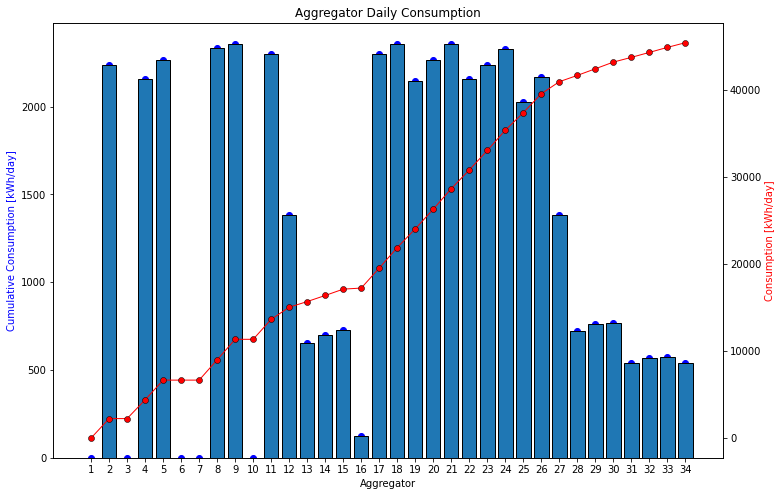

In [12]:
AGG_res_clean = AGG_res[AGG_res['Consumption'] != 0]

# fig, ax = plt.subplots(figsize=(12,8))
# ax.hist(AGG_res_clean.loc[:, 'Objective'], density=True, edgecolor='black', linewidth=0.5, bins=10)
# AGG_res.loc[:, 'Objective'].plot(kind='density')
# ax.set_title('Aggregator Objective');ax.set_xlabel('Objective [$/day]');ax.set_ylabel('PDF')
# fig.legend(bbox_to_anchor=(0.8,0.8), loc='center', borderaxespad=0);
#
# fig, ax = plt.subplots(figsize=(12,8))
# ax.hist(AGG_res_clean.loc[:, 'Consumption'], density=True, edgecolor='black', linewidth=0.5, bins=10)
# AGG_res.loc[:, 'Consumption'].plot(kind='density')
# ax.set_title('Aggregator Consumption');ax.set_xlabel('Consumption [kWh/day]');ax.set_ylabel('PDF')
# fig.legend(bbox_to_anchor=(0.8,0.8), loc='center', borderaxespad=0);

cumulative_cons = np.cumsum(AGG_res.loc[:, 'Consumption'])
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(AGG_res.loc[:, 'Consumption'].index, AGG_res.loc[:, 'Consumption'], ec='black')
ax.scatter(x=AGG_res.loc[:, 'Consumption'].index, y=AGG_res.loc[:, 'Consumption'], color='blue')
ax.set_title('Aggregator Daily Consumption');ax.set_xlabel('Aggregator');ax.set_ylabel('Cumulative Consumption [kWh/day]', color="blue")
ax2=ax.twinx()
ax2.plot(cumulative_cons, '-o', lw=1, alpha=1, markeredgecolor='k', markeredgewidth=0.5, color='red')
ax2.set_ylabel('Consumption [kWh/day]', color="red")
ax2.set_xticks(AGG_res.index)
ax2.set_xticklabels(AGG_res.index, rotation=45);